In [1]:
import uproot
import awkward
import numpy as np
import os
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from graph import SparseGraph, make_sparse_graph, \
                  save_graph, save_graphs, load_graph, \
                  load_graphs, make_sparse_graph, graph_from_sparse, \
                  draw_sample_validation, draw_sample3d, Graph

from preprocessing import make_graph_xy, make_graph_etaphi, make_graph_knn, make_graph_kdtree, make_graph_noedge
preprocessing_algo = make_graph_noedge
#preprocessing_algo = make_graph_etaphi
#grouping_algo = make_graph_knn
#preprocessing_args= dict(r = 0.07)
#preprocessing_args= dict(k=4)
#layer_norm = 150

#fname = '../../../data/D41/photon_flatE/FlatRandomEGunProducer_sitong_20190703/partGun_PDGid22_x1000_E2.0To100.0_NTUP_1.root'
#fname = './partGun_PDGid22_x1000_E2.0To100.0_NTUP_10.root'

fname = '../../data/ntup/partGun_PDGid15_x1000_Pt3.0To100.0_NTUP_1.root'

test = uproot.open(fname)['ana']['hgc']

%load_ext autoreload
%autoreload 2

In [2]:
#example of generating a binary ground-truth adjacency matrix 
#for both endcaps in all events for all clusters
#truth is now that hits in adjacent layers are connected 
#and so are hits in the same layer within delta-R < 2 
arrays = test.arrays([b'simcluster_hits_indices'])
rechit = test.arrays([b'rechit_x',b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi',
                      b'rechit_layer',b'rechit_time',b'rechit_energy'])
NEvents = rechit[b'rechit_z'].shape[0]
rechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1
sim_indices = awkward.fromiter(arrays[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]



def get_features(ievt,mask):
    x = rechit_x[ievt][mask]
    y = rechit_y[ievt][mask]
    layer = rechit_layer[ievt][mask]
    time = rechit_time[ievt][mask]
    energy = rechit_energy[ievt][mask]    
    return np.stack((x,y,layer,time,energy)).T

for ievt in tqdm(range(NEvents),desc='events processed'):
    #make input graphs
    
    #pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] > 0,
    #                               layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)
    #neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] < 0,
    #                               layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)
    
    pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] > 0)
    neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] < 0)
    
    #write the graph and truth graph out
    outbase = fname.split('/')[-1].replace('.root','')
    outdir = "/".join(fname.split('/')[:-2]) + "/npz/" + outbase +"/raw/"
    if not os.path.exists( outdir):
        os.makedirs(outdir)
    
    #graph = make_sparse_graph(*pos_graph)
    #save_graph(graph, '%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt))
    save_graph(pos_graph, '%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt))
        
    #graph = make_sparse_graph(*neg_graph)
    #save_graph(graph, '%s/%s_hgcal_graph_neg_evt%d.npz'%(outdir,outbase,ievt))
    save_graph(neg_graph, '%s/%s_hgcal_graph_neg_evt%d.npz'%(outdir,outbase,ievt))

(<Figure size 1440x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b719d6048>)

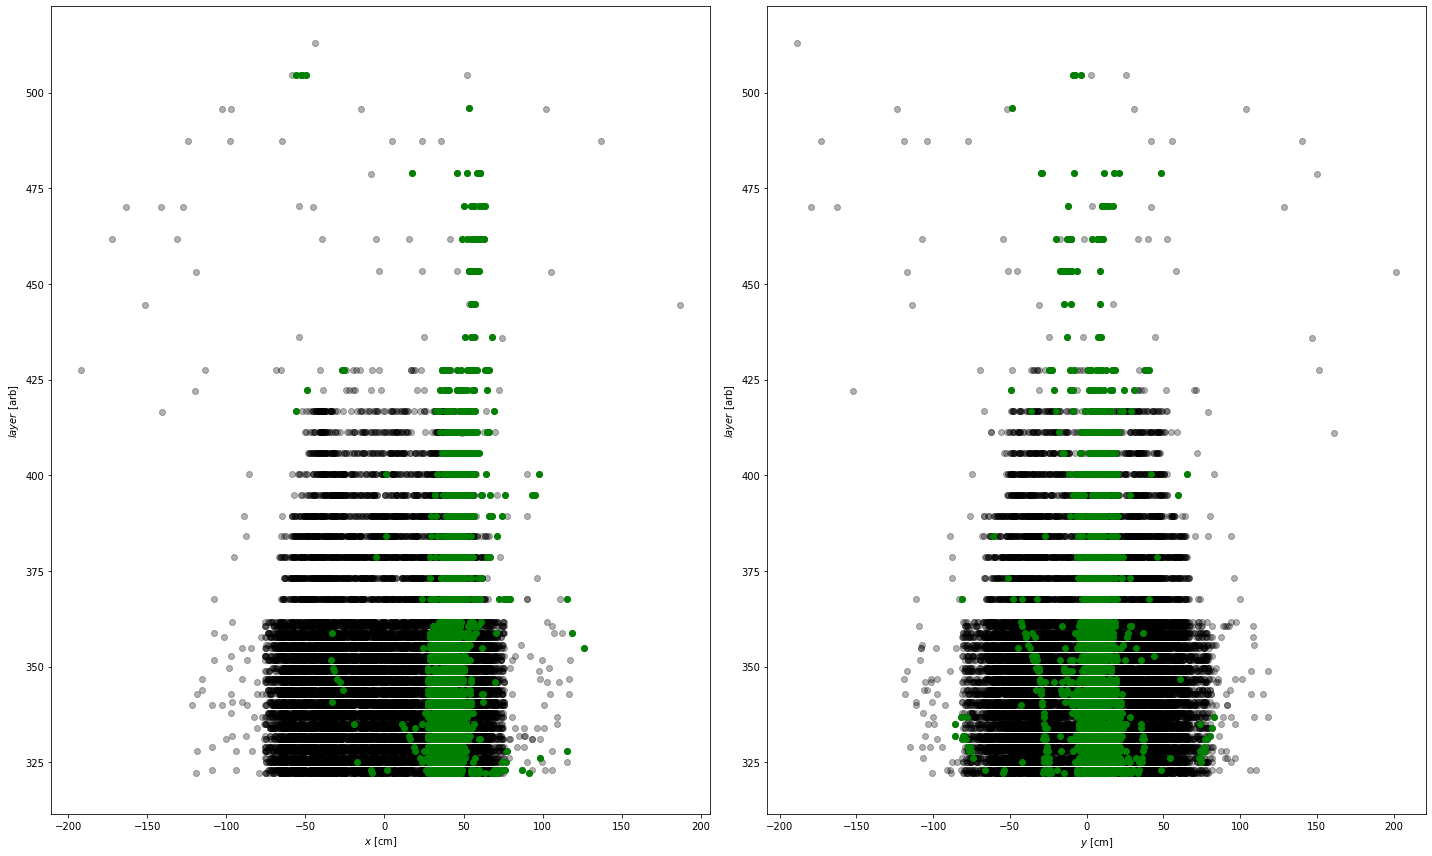

In [3]:
ievt = 0

#g1sparse = load_graph('%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt))
#g1 = graph_from_sparse(g1sparse)

g1 = load_graph('%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt), graph_type=Graph)

#g1 = load_graph('partGun_PDGid13_x1000_Pt3.0To100.0_NTUP_1_hgcal_graph_neg_evt0.npz')

draw_sample_validation(g1.X,g1.Ri,g1.Ro,g1.y,
            sim_list=g1.simmatched, 
            skip_false_edges=False)

(<Figure size 1440x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b707aeb38>)

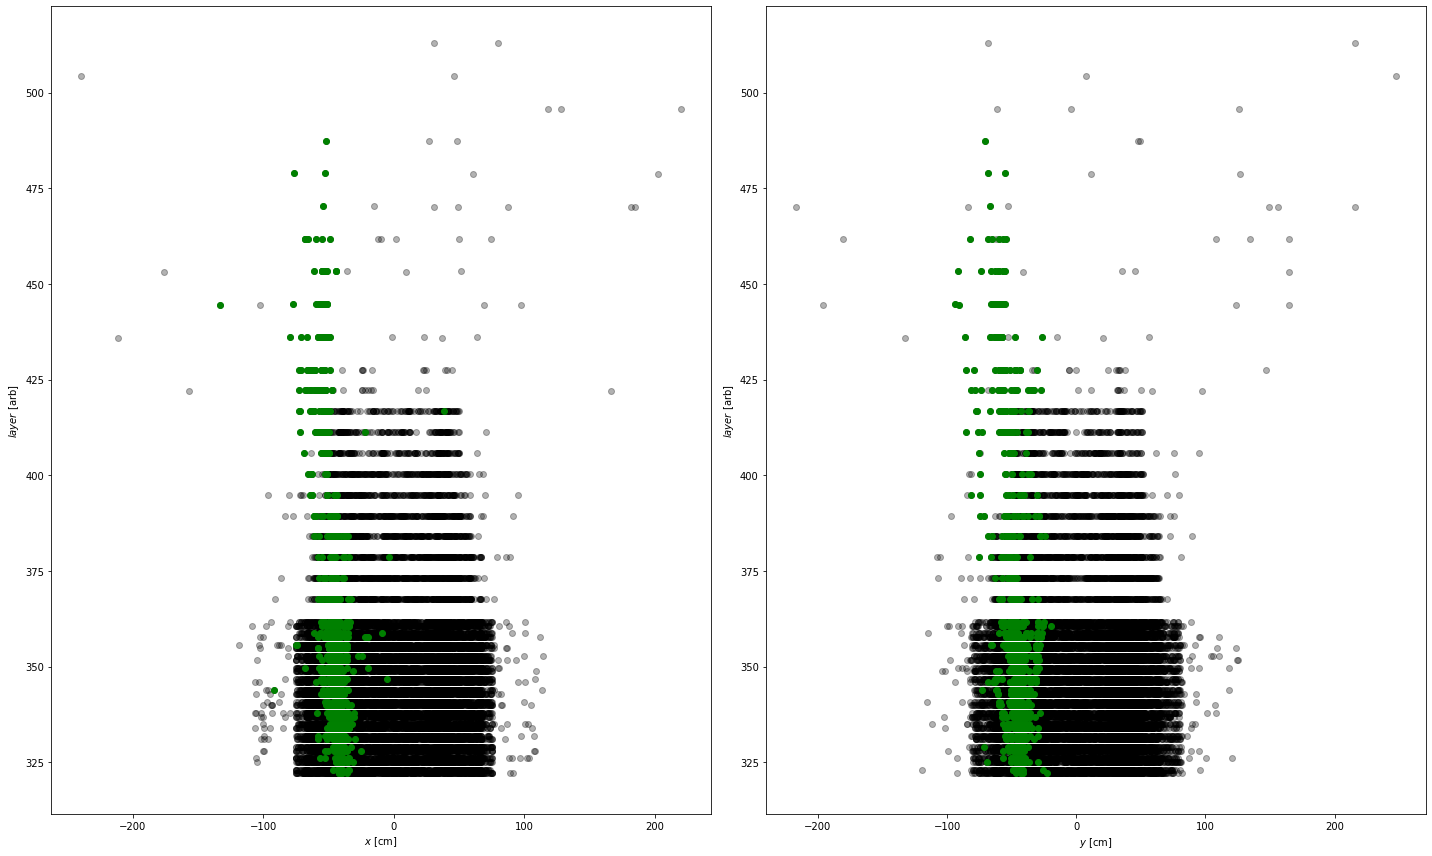

In [5]:
ievt = 3
#g2sparse = load_graph('%s/%s_hgcal_graph_pos_evt%d.npz'%(outbase,outbase,ievt))
#g2 = graph_from_sparse(g2sparse)

g2 = load_graph('%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt), graph_type=Graph)

draw_sample_validation(g2.X,g2.Ri,g2.Ro,g2.y,
            sim_list=g2.simmatched)